In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib import animation
import random

In [2]:
from JSAnimation.IPython_display import display_animation
from IPython.display import display, HTML

## 重新认识 cartpole 环境

- 小滑块/倒立摆
- 典型的 mdp（markov decision process）
    - 下一时刻的状态（转移）$s_{t+1}$ 只跟当前状态 $s_t$ 和（当前状态下采取的）$a_t$ 有关
- action space is discrete and finite
- state（observation）space is continuous

In [4]:
env = gym.make('CartPole-v1')

### state/space

In [5]:
# init space
env.reset()

(array([ 0.00344678,  0.00919252, -0.02831237,  0.03140745], dtype=float32),
 {})

In [6]:
# action space
print(env.action_space)

Discrete(2)


In [7]:
print(env.action_space.n)

2


In [8]:
# observation space
# https://www.gymlibrary.dev/environments/classic_control/cart_pole/
print(env.observation_space)
print(env.observation_space.low)
print(env.observation_space.high)
print(env.observation_space.shape[0])

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
4


### one episode

In [12]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
# observation = env.reset()
state = env.reset()
steps = 0
frames = []
while True:
    frames.append(env.render())
    action = env.action_space.sample()
    state, reward, terminated, truncated, info = env.step(action)
    steps += 1
    print(f'step: {steps}, state: {state}')
    if terminated or truncated:
        break

step: 1, state: [-0.03747194  0.17052297 -0.00884661 -0.28529757]
step: 2, state: [-0.03406148  0.36576995 -0.01455256 -0.5807575 ]
step: 3, state: [-0.02674608  0.17085493 -0.02616771 -0.29269415]
step: 4, state: [-0.02332899  0.36634    -0.0320216  -0.59351385]
step: 5, state: [-0.01600219  0.17168057 -0.04389187 -0.3110871 ]
step: 6, state: [-0.01256858  0.36739948 -0.05011361 -0.6172828 ]
step: 7, state: [-0.00522059  0.5631844  -0.06245927 -0.92531866]
step: 8, state: [ 0.0060431   0.75909173 -0.08096565 -1.2369578 ]
step: 9, state: [ 0.02122494  0.95515525 -0.1057048  -1.5538675 ]
step: 10, state: [ 0.04032804  1.1513735  -0.13678215 -1.8775715 ]
step: 11, state: [ 0.06335551  0.95798296 -0.17433359 -1.6302838 ]
step: 12, state: [ 0.08251517  1.154672   -0.20693925 -1.9718401 ]
step: 13, state: [ 0.10560861  1.3512911  -0.24637607 -2.320883  ]


In [13]:
frames

[array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
  

In [14]:
def display_frames_as_gif(frames, output):
    """
    Displays a list of frames as a gif, with controls
    以gif格式显示关键帧列，带有控件
    """
    
    fig = plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0),dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    
    def animate(i):
        img = patch.set_data(frames[i])
        return img   ## *** return是必须要有的 ***
        
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    
    anim.save(output)
    return HTML(anim.to_jshtml())  ## *** 返回一个HTML对象，以便被调用者显示。 ***
    # display(display_animation(anim, default_mode='loop'))

MovieWriter ffmpeg unavailable; using Pillow instead.


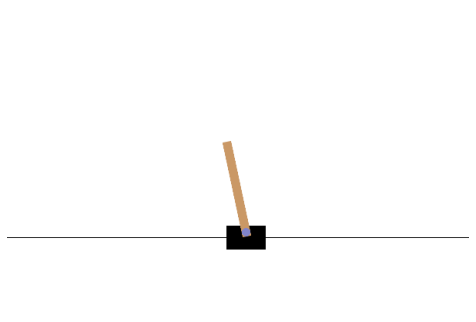

In [16]:
display_frames_as_gif(frames, output='./save/rand_cartpole.gif')
# display_frames_as_gif(frames, output='./save/rand_cartpole.mp4')

## 状态离散化

In [17]:
NUM_DIGITIZED = 6

# 分桶， 5个值，对应 6 个分段，即 6 个桶 (0, 1, 2, 3, 4, 5)
def bins(clip_min, clip_max, num_bins=NUM_DIGITIZED):
    return np.linspace(clip_min, clip_max, num_bins+1)[1:-1]

# 按 6 进制映射将 4位 6 进制数映射为 id，
def digitize_state(observation):
    pos, cart_v, angle, pole_v = observation
    digitized = [np.digitize(pos, bins=bins(-2.4, 2.4, NUM_DIGITIZED)), 
                 np.digitize(cart_v, bins=bins(-3., 3, NUM_DIGITIZED)), 
                 np.digitize(angle, bins=bins(-0.418, 0.418, NUM_DIGITIZED)), 
                 np.digitize(pole_v, bins=bins(-2, 2, NUM_DIGITIZED))]
    # 3,1,2,4 (4位10进制数) = 4*10^0 + 2*10^1 + 1*10^2 + 3*10^3，最终的取值范围是 0-9999，总计 10^4 == 10000
    # a,b,c,d (4位6进制数) = d*6^0 + c*6^1 + b*6^2 + a*6^3，最终的取值范围是 0-`5555`(1295)，总计 6^4 == 1296
    ind = sum([d*(NUM_DIGITIZED**i) for i, d in enumerate(digitized)])
    return ind
    

In [18]:
obs = env.reset()

In [19]:
obs

(array([-0.04797409, -0.04457007,  0.00209891, -0.02967812], dtype=float32),
 {})

In [20]:
bins(-2.4, 2.4, NUM_DIGITIZED)

array([-1.6, -0.8,  0. ,  0.8,  1.6])

## q-learning

In [21]:
class Agent:
    def __init__(self, action_space, n_states, eta=0.5, gamma=0.99, NUM_DIGITIZED=6):
        self.eta = 0.5
        self.gamme = gamma
        # Discrete(2)
        self.action_space = action_space
        self.NUM_DIGITIZED = NUM_DIGITIZED
        self.q_table = np.random.uniform(0, 1, size=(NUM_DIGITIZED**n_states, self.action_space.n))
        
    # 分桶， 5个值，对应 6 个分段，即 6 个桶 (0, 1, 2, 3, 4, 5)
    @staticmethod
    def _bins(clip_min, clip_max, num_bins):
        return np.linspace(clip_min, clip_max, num_bins+1)[1:-1]

    # 按 6 进制映射将 4位 6 进制数映射为 id，
    @staticmethod
    def _digitize_state(observation, NUM_DIGITIZED):
        pos, cart_v, angle, pole_v = observation
        digitized = [np.digitize(pos, bins=Agent._bins(-2.4, 2.4, NUM_DIGITIZED)), 
                     np.digitize(cart_v, bins=Agent._bins(-3., 3, NUM_DIGITIZED)), 
                     np.digitize(angle, bins=Agent._bins(-0.418, 0.418, NUM_DIGITIZED)), 
                     np.digitize(pole_v, bins=Agent._bins(-2, 2, NUM_DIGITIZED))]
        # 3,1,2,4 (4位10进制数) = 4*10^0 + 2*10^1 + 1*10^2 + 3*10^3，最终的取值范围是 0-9999，总计 10^4 == 10000
        # a,b,c,d (4位6进制数) = d*6^0 + c*6^1 + b*6^2 + a*6^3，最终的取值范围是 0-`5555`(1295)，总计 6^4 == 1296
        ind = sum([d*(NUM_DIGITIZED**i) for i, d in enumerate(digitized)])
        return ind

#     def update_q_table()
    def q_learning(self, obs, action, reward, obs_next):
        obs_ind = Agent._digitize_state(obs, self.NUM_DIGITIZED)
        obs_next_ind = Agent._digitize_state(obs_next, self.NUM_DIGITIZED)
        self.q_table[obs_ind, action] = self.q_table[obs_ind, action] + self.eta*(reward + max(self.q_table[obs_next_ind, :]) - self.q_table[obs_ind, action])
        
    def choose_action(self, state, episode):
        eps = 0.5*1/(episode + 1)
        state_ind = Agent._digitize_state(state, self.NUM_DIGITIZED)
        # epsilon greedy
        if random.random() < eps:
            action = self.action_space.sample()
        else:
            action = np.argmax(self.q_table[state_ind, :])
        return action

In [43]:
env = gym.make('CartPole-v0', render_mode='rgb_array')
env.reset()
action_space = env.action_space
n_states = env.observation_space.shape[0]

agent = Agent(action_space, n_states)

max_episodes = 6000
max_steps = 200

continue_success_episodes = 0
learning_finish_flag = False

frames = []

for episode in range(max_episodes):
    obs = env.reset()[0]
    for step in range(max_steps):
        if learning_finish_flag:
            frames.append(env.render())
        action = agent.choose_action(obs, episode)
        obs_next, _, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            if step < 195:
                reward = -1
                continue_success_episodes = 0
            else:
                reward = 1
                continue_success_episodes += 1
        else:
            reward = 0
        
        agent.q_learning(obs, action, reward, obs_next)
        
        if terminated or truncated:
            print(f'episode: {episode}, finish {step} time steps.')
            break
            
        obs = obs_next
        
    if learning_finish_flag:
        break
    if continue_success_episodes >= 10:
        learning_finish_flag = True
        print(f'continue success(step > 195) more than 10 times ')


c:\Users\10128\miniconda3\envs\rl\lib\site-packages\gymnasium\envs\registration.py:523: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


episode: 0, finish 39 time steps.
episode: 1, finish 15 time steps.
episode: 2, finish 9 time steps.
episode: 3, finish 7 time steps.
episode: 4, finish 10 time steps.
episode: 5, finish 37 time steps.
episode: 6, finish 22 time steps.
episode: 7, finish 77 time steps.
episode: 8, finish 27 time steps.
episode: 9, finish 25 time steps.
episode: 10, finish 11 time steps.
episode: 11, finish 12 time steps.
episode: 12, finish 90 time steps.
episode: 13, finish 14 time steps.
episode: 14, finish 38 time steps.
episode: 15, finish 10 time steps.
episode: 16, finish 8 time steps.
episode: 17, finish 19 time steps.
episode: 18, finish 29 time steps.
episode: 19, finish 9 time steps.
episode: 20, finish 38 time steps.
episode: 21, finish 8 time steps.
episode: 22, finish 22 time steps.
episode: 23, finish 174 time steps.
episode: 24, finish 34 time steps.
episode: 25, finish 12 time steps.
episode: 26, finish 112 time steps.
episode: 27, finish 129 time steps.
episode: 28, finish 69 time step

MovieWriter ffmpeg unavailable; using Pillow instead.


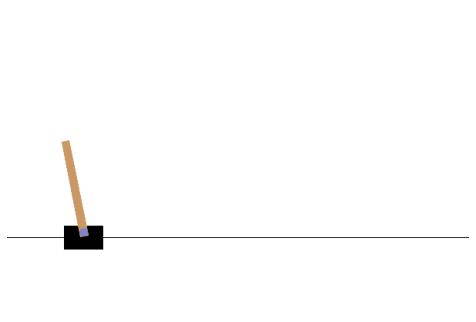

In [44]:
display_frames_as_gif(frames, output='./save/cart_pole_q_learrning.gif')